In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import control as ct
import control.optimal as opt
import control.flatsys as fs
from IPython.display import Image

# Define line styles
ebarstyle = {"elinewidth": 0.5, "capsize": 2}
xdstyle = {
    "color": "k",
    "linestyle": "--",
    "linewidth": 0.5,
    "marker": "+",
    "markersize": 4,
}

In [4]:
# Vehicle steering dynamics
#
# System state: x, y, theta
# System input: v, phi
# System output: x, y
# System parameters: wheelbase, maxsteer
#
from vehicle import vehicle, plot_lanechange

print(vehicle)

<FlatSystem>: vehicle
Inputs (2): ['v', 'delta']
Outputs (3): ['x', 'y', 'theta']
States (3): ['x', 'y', 'theta']

Update: <function _vehicle_update at 0x0000026B98340790>
Output: <function _vehicle_output at 0x0000026B983408B0>

Forward: <function _vehicle_flat_forward at 0x0000026B983401F0>
Reverse: <function _vehicle_flat_reverse at 0x0000026B98340670>


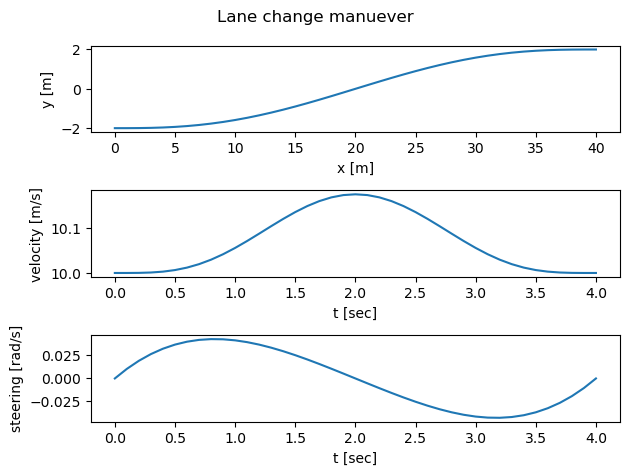

In [5]:
# Generate a trajectory for the vehicle
# Define the endpoints of the trajectory
x0 = [0.0, -2.0, 0.0]
u0 = [10.0, 0.0]
xf = [40.0, 2.0, 0.0]
uf = [10.0, 0.0]
Tf = 4

# Find a trajectory between the initial condition and the final condition
traj = fs.point_to_point(vehicle, Tf, x0, u0, xf, uf, basis=fs.PolyFamily(6))

# Create the desired trajectory between the initial and final condition
Ts = 0.1
# Ts = 0.5
T = np.arange(0, Tf + Ts, Ts)
xd, ud = traj.eval(T)

plot_lanechange(T, xd, ud)

In [6]:
#
# Create a discrete time, linear model
#

# Linearize about the starting point
linsys = ct.linearize(vehicle, x0, u0)

# Create a discrete time model by hand
Ad = np.eye(linsys.nstates) + linsys.A * Ts
Bd = linsys.B * Ts
discsys = ct.LinearIOSystem(ct.ss(Ad, Bd, np.eye(linsys.nstates), 0, dt=Ts))
print(discsys)

<LinearIOSystem>: sys[3]
Inputs (2): ['u[0]', 'u[1]']
Outputs (3): ['y[0]', 'y[1]', 'y[2]']
States (3): ['x[0]', 'x[1]', 'x[2]']

A = [[ 1.0000000e+00  0.0000000e+00 -5.0004445e-07]
     [ 0.0000000e+00  1.0000000e+00  1.0000000e+00]
     [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]

B = [[0.1        0.        ]
     [0.         0.        ]
     [0.         0.33333333]]

C = [[1. 0. 0.]
     [0. 1. 0.]
     [0. 0. 1.]]

D = [[0. 0.]
     [0. 0.]
     [0. 0.]]

dt = 0.1



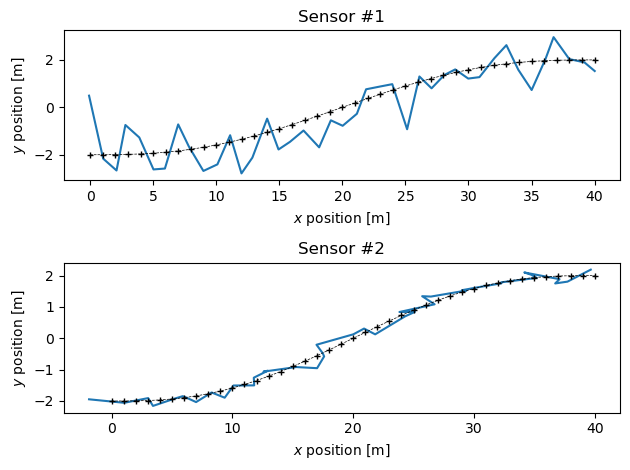

In [7]:
# Sensor #1: longitudinal
C_lon = np.eye(2, discsys.nstates)
Rw_lon = np.diag([0.1**2, 1**2])
W_lon = ct.white_noise(T, Rw_lon, dt=Ts)

# Sensor #2: lateral
C_lat = np.eye(2, discsys.nstates)
Rw_lat = np.diag([1**2, 0.1**2])
W_lat = ct.white_noise(T, Rw_lat, dt=Ts)

# Plot the noisy signals
plt.subplot(2, 1, 1)
Y = xd[0:2] + W_lon
plt.plot(Y[0], Y[1])
plt.plot(xd[0], xd[1], **xdstyle)
plt.xlabel("$x$ position [m]")
plt.ylabel("$y$ position [m]")
plt.title("Sensor #1")

plt.subplot(2, 1, 2)
Y = xd[0:2] + W_lat
plt.plot(Y[0], Y[1])
plt.plot(xd[0], xd[1], **xdstyle)
plt.xlabel("$x$ position [m]")
plt.ylabel("$y$ position [m]")
plt.title("Sensor #2")
plt.tight_layout()

In [8]:
#
# Create an estimator for the system
#

# Disturbance and initial condition model
Rv = np.diag([0.1, 0.01]) * Ts
# Rv = np.diag([10, 0.1]) * Ts  # No input data
P0 = np.diag([1, 1, 0.1])

# Combine the sensors
C = np.vstack([C_lon, C_lat])
Rw = sp.linalg.block_diag(Rw_lon, Rw_lat)

estim = ct.create_estimator_iosystem(discsys, Rv, Rw, C=C, P0=P0)
print(estim)

<NonlinearIOSystem>: sys[4]
Inputs (6): ['y[0]', 'y[1]', 'y[2]', 'y[3]', 'u[0]', 'u[1]']
Outputs (3): ['xhat[0]', 'xhat[1]', 'xhat[2]']
States (12): ['xhat[0]', 'xhat[1]', 'xhat[2]', 'P[0,0]', 'P[0,1]', 'P[0,2]', 'P[1,0]', 'P[1,1]', 'P[1,2]', 'P[2,0]', 'P[2,1]', 'P[2,2]']

Update: <function create_estimator_iosystem.<locals>._estim_update at 0x0000026B9893AB80>
Output: <function create_estimator_iosystem.<locals>._estim_output at 0x0000026B9893AC10>
